In [1]:
import numpy as np

def read_sounding_file(filepath):
    # Initialize empty lists for storing extracted values
    ps = None
    zs = []
    Thetas = []
    qs = []
    us = []
    vs = []
    
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Split each line into values
            values = line.split()
            # Extract ps from the first line
            if ps is None:
                ps = float(values[0])
            else:
                # Extract other values from subsequent lines
                zs.append(float(values[0]))
                Thetas.append(float(values[1]))
                qs.append(float(values[2]))
                us.append(float(values[3]))
                vs.append(float(values[4]))
    
    # Convert lists to numpy arrays
    zs = np.array(zs)
    Thetas = np.array(Thetas)
    qs = np.array(qs)
    us = np.array(us)
    vs = np.array(vs)
    
    return ps, zs, Thetas, qs, us, vs

#############################################1
# Methode, um sound_in Datei zu schreiben:

def write_sounding_string(ps=1013.25, zs=np.array([500,1000,1500]), Thetas=np.array([288, 289, 300]),\
                          qs=np.array([10.1, 8, 9]), us=np.array([7, 6, 8]), vs=np.array([7, 6, 8]), zmax=5000,
                         filename = "sound_in_python"):
    
    # Erste Zeile mit ps und den ersten Werten von Thetas, qs, us, vs
    text = f"  {ps:8.3f}{'':3}".zfill(8)
    for values in [Thetas[0], qs[0], us[0], vs[0]]:
        text += f"{values:7.3f}{'':3}".zfill(7)

    # Zeilen 2 bis len(zs)+1
    for z, Theta, q, u, v in zip(zs, Thetas, qs, us, vs):
        ###########
        # Ist die Null in zweiter Zeile Grund fuer dne Abbruch?
        if z==0:
            continue
        ##########3
        text += f"\n  {z:8.3f}{'':3}".zfill(8)
        for values in [Theta, q, u, v]:
            text += f"{values:7.3f}{'':3}".zfill(7)
            
        ########33
        # Abbruch in unterer Atmosphaere:
        if z>zmax:
            break
        ###########
            
    new_file = open(filename,"w")
    new_file.write(text)
    new_file.close()

    return text

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(0.0, 2000.0)

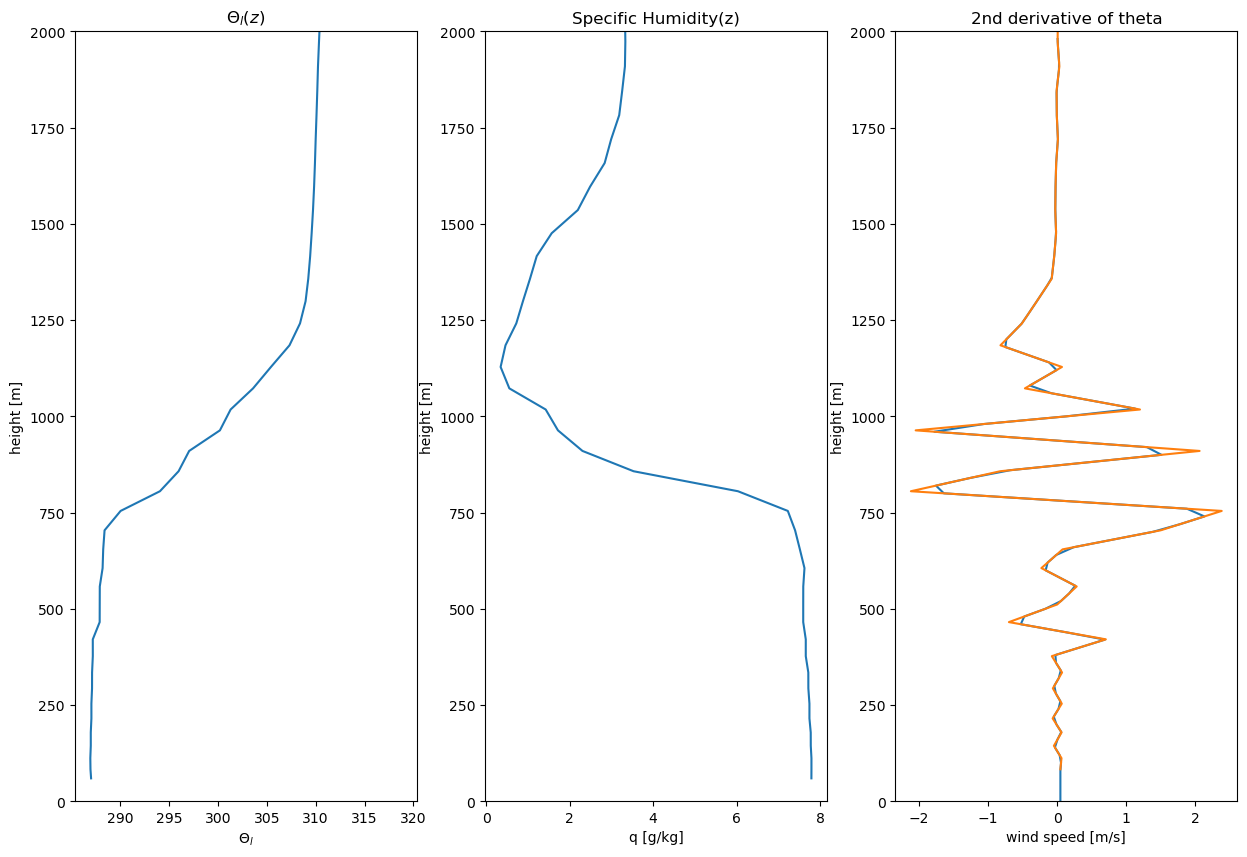

In [2]:
import matplotlib.pyplot as plt
import xarray as xr

ds_theta_v4 = xr.open_dataset("/home/qwertz/obs_data_MA/iqq_foghat/theta_v_spec_hum_iqq_22_23apschera20240304.nc")
iconles_iqq22 = "sound_in_iconles"
iqq22 ="sound_in_IQQ2018-08-22T09 13 00"
iqq23 ="sound_in_IQQ2018-08-23T21 37 59"

ps, zs, Thetas, qs, us, vs = read_sounding_file(iconles_iqq22)

fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)

In [3]:
# How would I write a function to sharpen a Theta and q profile??
# 1 detect inversion base and top:

def detect_zheight(zs, Thetas):
    zb = np.nan
    zi = np.nan
    found_zb = False
    for i, theta_deriv in enumerate(np.diff(np.diff(Thetas))):
        if abs(theta_deriv) > 1.25 and not found_zb:
            found_zb = True
            zb = zs[i]
        elif abs(theta_deriv) > 0.75:
            zi = zs[i]
        if zs[i] > 2000:
            break
    return zb, zi

#####################################

zb, zi = detect_zheight(zs, Thetas)

#######################################
# 3 bring them closer together by a certain factor, reducing the gradient!

def sharpen_inversion(zb, zi, zs, Thetas,qs, sharpness=2., pushdown_base = 0, pushdown_top=0, raise_top=2):
    zb = zs[int(np.where(zb==zs)[0])-pushdown_base]
    zi = zs[int(np.where(zi==zs)[0])-pushdown_top]
    new_Thetas = np.zeros([len(Thetas)])
    new_qs = np.zeros([len(Thetas)])
    dz = zi - zb
    remainder = dz - dz/sharpness
    indices = []
    
    '''
    for i, (z, Theta) in enumerate(zip(zs,Thetas)):
        if z > zb and z < zb+remainder/2:
            new_Thetas[i] = Thetas[i-1]
            new_qs[i] = qs[i-1]
        elif z > (zb+remainder/2) and z < (zi-remainder/2):
            indices.append(i)
        elif z > zi-remainder/2 and z < zi:  
            new_Thetas[i] = Thetas[int(np.where(zb==zs)[0])]
        else:
            new_Thetas[i] = Thetas[i]
    '''
    for i, (z, Theta) in enumerate(zip(zs,Thetas)):
        if z > zb and z < zb+remainder: # Wenn wir in der Inversion sind
            indices.append(i)
        elif z > zi-remainder and z < zi:   # Wenn wir über dem interpolierten Teil sind, aber innerhalb der alten Inversion
            # Standard:
            # new_Thetas[i] = Thetas[int(np.where(zb==zs)[0
            ##############
            # Alternativ:
            new_Thetas[i] = Thetas[int(np.where(zb==zs)[0])] + raise_top
        elif z > zi: # Wenn wir über der Inversion sind:
            # Standard:
            # new_Thetas[i] = Thetas[i]
            ##############
            # Alternativ:
            new_Thetas[i] = Thetas[i]+ raise_top
        else:
            new_Thetas[i] = Thetas[i]

    new_Thetas[indices] = np.interp(zs[indices],[zs[indices[0]], zs[indices[-1]]],\
                                  [Thetas[indices[0]-1] , Thetas[int(np.where(zb==zs)[0])]])
    return new_Thetas, new_qs

#########################################

new_Thetas, new_qs = sharpen_inversion(zb, zi, zs, Thetas, qs, sharpness=8., pushdown_base = 5, pushdown_top=0)


/tmp/ipykernel_46290/4038511044.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zb = zs[int(np.where(zb==zs)[0])-pushdown_base]
/tmp/ipykernel_46290/4038511044.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zi = zs[int(np.where(zi==zs)[0])-pushdown_top]
/tmp/ipykernel_46290/4038511044.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_Thetas[i] = Thetas[int(np.where(zb==zs)[0])] + raise_top
/tmp/ipykernel_46290/4038511044.py:65: DeprecationWarning:

In [4]:
#######################################
# 3 bring them closer together by a certain factor, reducing the gradient!
465.487
511.278
558.061
605.789
654.422
703.926
754.27
805.426
857.369
910.078
963.532
1017.713
1072.604
1128.191
1184.46
1241.397
1298.991
1357.232
1416.109

def new_sharpen_inversion(zs, Thetas,qs, zb=963.532, dz=100, zi=zi, between=[600,1300], raise_top=0, raise_abl=0):
    # Icon Les: dz: 100: between 500 and 1300; zb von oben ermittelt
    new_Thetas = np.zeros([len(Thetas)])
    new_qs = np.zeros([len(Thetas)])
    indices = []
    
    # T auf 1500 und 500 m:
    topindex = np.argmin(abs(between[1]-zs))
    baseindex = np.argmin(abs(between[0]-zs))
    ttop = Thetas[topindex]
    tbase = Thetas[baseindex]
    qtop = qs[topindex]
    qbase = qs[baseindex]
    
    for i, (z, Theta) in enumerate(zip(zs,Thetas)):
        print(z)
        # if z > zs[baseindex] and z < zb:
        if z < zb:
            new_Thetas[i] = tbase + raise_abl
            new_qs[i] = qbase
        elif z >= zb and z <= zb+dz:
            indices.append(i)
        # elif z > zb+dz and z < zs[topindex]: # Über interpolationsbereich, aber in Inversion
        elif z > zb+dz:
            # Standard:
            new_Thetas[i] = ttop
            new_qs[i] = qtop
            ###############
            # Alternativ:
            new_Thetas[i] = ttop + raise_top

        '''
        elif z > zs[topindex]: # Wenn wir über der Inversion sind:
            # Standard:
            # new_Thetas[i] = Thetas[i]
            new_qs[i] = qs[i]
            ################
            # Alternativ:
            new_Thetas[i] = Thetas[i] + raise_top
        else:
            new_Thetas[i] = Thetas[i]
            new_qs[i] = qs[i]
        '''
            
    #######################3
    #new_Thetas[indices] = np.interp(zs[indices],[zs[indices[0]], zs[indices[-1]]],\
    #                              [Thetas[indices[0]-1] , Thetas[int(np.where(zb==zs)[0])]])  
    #new_qs[indices] = np.interp(zs[indices],[zs[indices[0]], zs[indices[-1]]],\
    #                              [qs[indices[0]-1] , qs[int(np.where(zb==zs)[0])]])  
    ####################################
    
    new_Thetas[indices] = np.interp(zs[indices],[zs[indices[0]], zs[indices[-1]]],\
                                  [tbase, ttop])  
    
    new_qs[indices] = np.interp(zs[indices],[zs[indices[0]], zs[indices[-1]]],\
                                  [qbase, qtop])  


    return new_Thetas, new_qs

#################################

new_Thetas, new_qs = new_sharpen_inversion(zs, Thetas,qs, zb=963.532, raise_abl=0)

##################################
# Korrigiere die kleien Macke in dem Profil mit der verschobenen Toptemperatur.


59.637
83.183
112.135
144.28
178.836
215.384
253.655
293.456
334.642
377.1
420.74
465.487
511.278
558.061
605.789
654.422
703.926
754.27
805.426
857.369
910.078
963.532
1017.713
1072.604
1128.191
1184.46
1241.397
1298.991
1357.232
1416.109
1475.613
1535.736
1596.469
1657.806
1719.739
1782.262
1845.369
1909.055
1973.314
2038.143
2103.535
2169.488
2235.998
2303.06
2370.671
2438.83
2507.531
2576.774
2646.556
2716.874
2787.726
2859.111
2931.027
3003.471
3076.444
3149.943
3223.968
3298.517
3373.59
3449.186
3525.303
3601.943
3679.104
3756.787
3834.99
3913.714
3992.959
4072.725
4153.013
4233.822
4315.152
4397.005
4479.382
4562.281
4645.706
4729.654
4814.129
4899.132
4984.662
5070.721


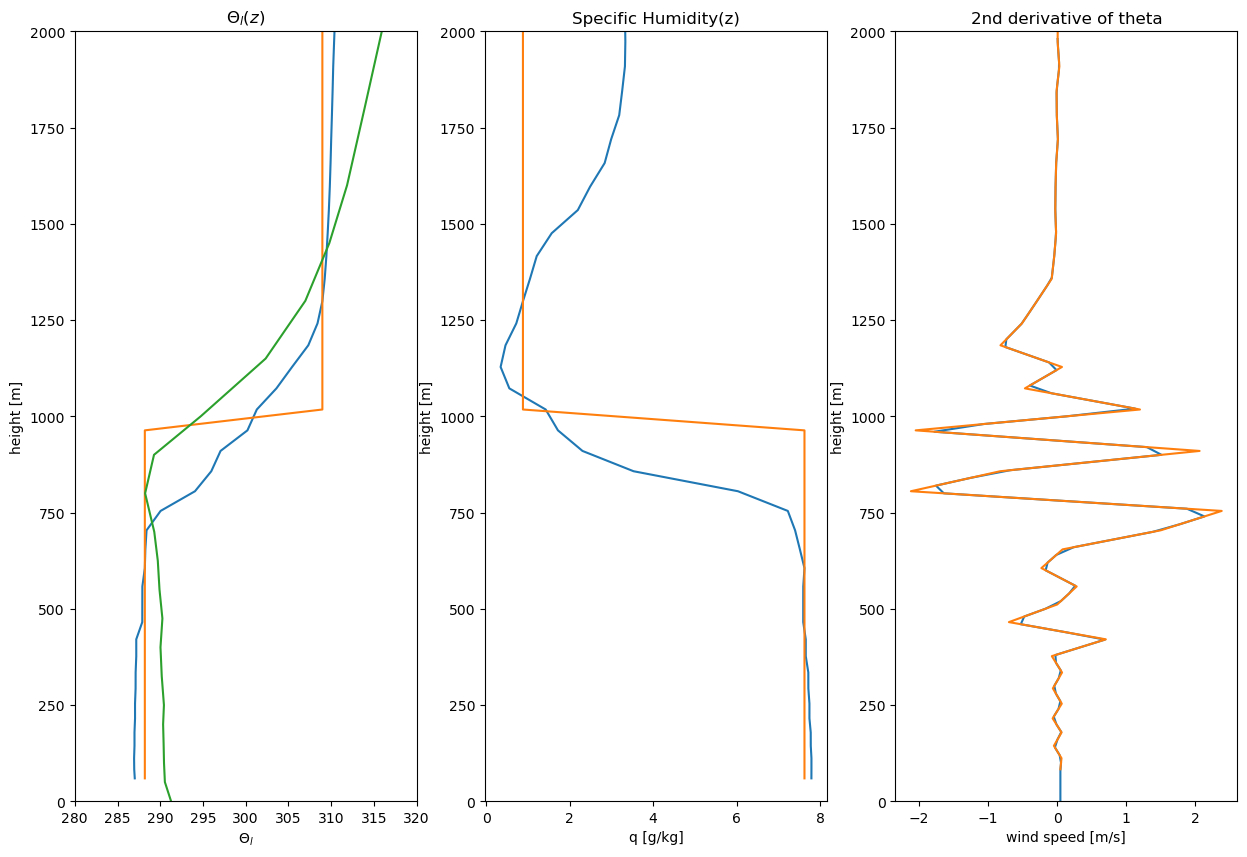

In [5]:
fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].plot(new_Thetas, zs)
axs[0].plot(ds_theta_v4['theta_l'].mean("time"), ds_theta_v4['height'])
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)
axs[0].set_xlim(280,320)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].plot(new_qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)
plt.savefig("/home/qwertz/Bilder/new_inversion.png", facecolor="white")

In [6]:
new_Thetas, new_qs = new_sharpen_inversion(zs, Thetas,qs, zb=700, raise_top=0, dz=550)

write_sounding_string(ps=ps, zs=zs, Thetas=new_Thetas,\
                          qs=new_qs, us=us, vs=vs, zmax=5000,
                         filename = "iconles_iqq22_unsharpened")

fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].plot(new_Thetas, zs)
axs[0].plot(ds_theta_v4['theta_l'].mean("time"), ds_theta_v4['height'])
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)
axs[0].set_xlim(280,320)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].plot(new_qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)
plt.savefig("/home/qwertz/Bilder/iconles_iqq22_unsharpened.png", facecolor="white")
plt.close()

##################################################

new_Thetas, new_qs = new_sharpen_inversion(zs, Thetas,qs, zb=963.532, raise_top=0)

write_sounding_string(ps=ps, zs=zs, Thetas=new_Thetas,\
                          qs=new_qs, us=us, vs=vs, zmax=5000,
                         filename = "iconles_iqq22_sharp")

fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].plot(new_Thetas, zs)
axs[0].plot(ds_theta_v4['theta_l'].mean("time"), ds_theta_v4['height'])
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)
axs[0].set_xlim(280,320)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].plot(new_qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)
plt.savefig("/home/qwertz/Bilder/iconles_iqq22_sharpened.png", facecolor="white")
plt.close()

##################################################

new_Thetas, new_qs = new_sharpen_inversion(zs, Thetas,qs, zb=963.532, raise_top=1)

write_sounding_string(ps=ps, zs=zs, Thetas=new_Thetas,\
                          qs=new_qs, us=us, vs=vs, zmax=5000,
                         filename = "iconles_iqq22_sharp_FT_plus1K")

fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].plot(new_Thetas, zs)
axs[0].plot(ds_theta_v4['theta_l'].mean("time"), ds_theta_v4['height'])
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)
axs[0].set_xlim(280,320)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].plot(new_qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)
plt.savefig("/home/qwertz/Bilder/iconles_iqq22_sharp_FT_plus2K.png", facecolor="white")
plt.close()

##################################################

new_Thetas, new_qs = new_sharpen_inversion(zs, Thetas,qs, zb=963.532, raise_top=-1)

write_sounding_string(ps=ps, zs=zs, Thetas=new_Thetas,\
                          qs=new_qs, us=us, vs=vs, zmax=5000,
                         filename = "iconles_iqq22_sharp_FT_minus1K")

fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].plot(new_Thetas, zs)
axs[0].plot(ds_theta_v4['theta_l'].mean("time"), ds_theta_v4['height'])
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)
axs[0].set_xlim(280,320)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].plot(new_qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)
plt.savefig("/home/qwertz/Bilder/iconles_iqq22_sharp_FT_minus2K.png", facecolor="white")
plt.close()

##################################################

new_Thetas, new_qs = new_sharpen_inversion(zs, Thetas,qs, zb=963.532, raise_abl=1)

write_sounding_string(ps=ps, zs=zs, Thetas=new_Thetas,\
                          qs=new_qs, us=us, vs=vs, zmax=5000,
                         filename = "iconles_iqq22_sharp_ABL_plus1K")

fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].plot(new_Thetas, zs)
axs[0].plot(ds_theta_v4['theta_l'].mean("time"), ds_theta_v4['height'])
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)
axs[0].set_xlim(280,320)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].plot(new_qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)
plt.savefig("/home/qwertz/Bilder/iconles_iqq22_sharp_ABL_plus2K.png", facecolor="white")
plt.close()

##################################################

new_Thetas, new_qs = new_sharpen_inversion(zs, Thetas,qs, zb=963.532, raise_abl=-1)

write_sounding_string(ps=ps, zs=zs, Thetas=new_Thetas,\
                          qs=new_qs, us=us, vs=vs, zmax=5000,
                         filename = "iconles_iqq22_sharp_ABL_minus1K")

fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].plot(new_Thetas, zs)
axs[0].plot(ds_theta_v4['theta_l'].mean("time"), ds_theta_v4['height'])
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)
axs[0].set_xlim(280,320)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].plot(new_qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)
plt.savefig("/home/qwertz/Bilder/iconles_iqq22_sharp_ABL_minus2K.png", facecolor="white")
plt.close()

59.637
83.183
112.135
144.28
178.836
215.384
253.655
293.456
334.642
377.1
420.74
465.487
511.278
558.061
605.789
654.422
703.926
754.27
805.426
857.369
910.078
963.532
1017.713
1072.604
1128.191
1184.46
1241.397
1298.991
1357.232
1416.109
1475.613
1535.736
1596.469
1657.806
1719.739
1782.262
1845.369
1909.055
1973.314
2038.143
2103.535
2169.488
2235.998
2303.06
2370.671
2438.83
2507.531
2576.774
2646.556
2716.874
2787.726
2859.111
2931.027
3003.471
3076.444
3149.943
3223.968
3298.517
3373.59
3449.186
3525.303
3601.943
3679.104
3756.787
3834.99
3913.714
3992.959
4072.725
4153.013
4233.822
4315.152
4397.005
4479.382
4562.281
4645.706
4729.654
4814.129
4899.132
4984.662
5070.721
59.637
83.183
112.135
144.28
178.836
215.384
253.655
293.456
334.642
377.1
420.74
465.487
511.278
558.061
605.789
654.422
703.926
754.27
805.426
857.369
910.078
963.532
1017.713
1072.604
1128.191
1184.46
1241.397
1298.991
1357.232
1416.109
1475.613
1535.736
1596.469
1657.806
1719.739
1782.262
1845.369
1909.055
19

59.637
83.183
112.135
144.28
178.836
215.384
253.655
293.456
334.642
377.1
420.74
465.487
511.278
558.061
605.789
654.422
703.926
754.27
805.426
857.369
910.078
963.532
1017.713
1072.604
1128.191
1184.46
1241.397
1298.991
1357.232
1416.109
1475.613
1535.736
1596.469
1657.806
1719.739
1782.262
1845.369
1909.055
1973.314
2038.143
2103.535
2169.488
2235.998
2303.06
2370.671
2438.83
2507.531
2576.774
2646.556
2716.874
2787.726
2859.111
2931.027
3003.471
3076.444
3149.943
3223.968
3298.517
3373.59
3449.186
3525.303
3601.943
3679.104
3756.787
3834.99
3913.714
3992.959
4072.725
4153.013
4233.822
4315.152
4397.005
4479.382
4562.281
4645.706
4729.654
4814.129
4899.132
4984.662
5070.721


FileNotFoundError: [Errno 2] No such file or directory: '/home/alexander/Pictures/foghat_iqq23_sharp.png'

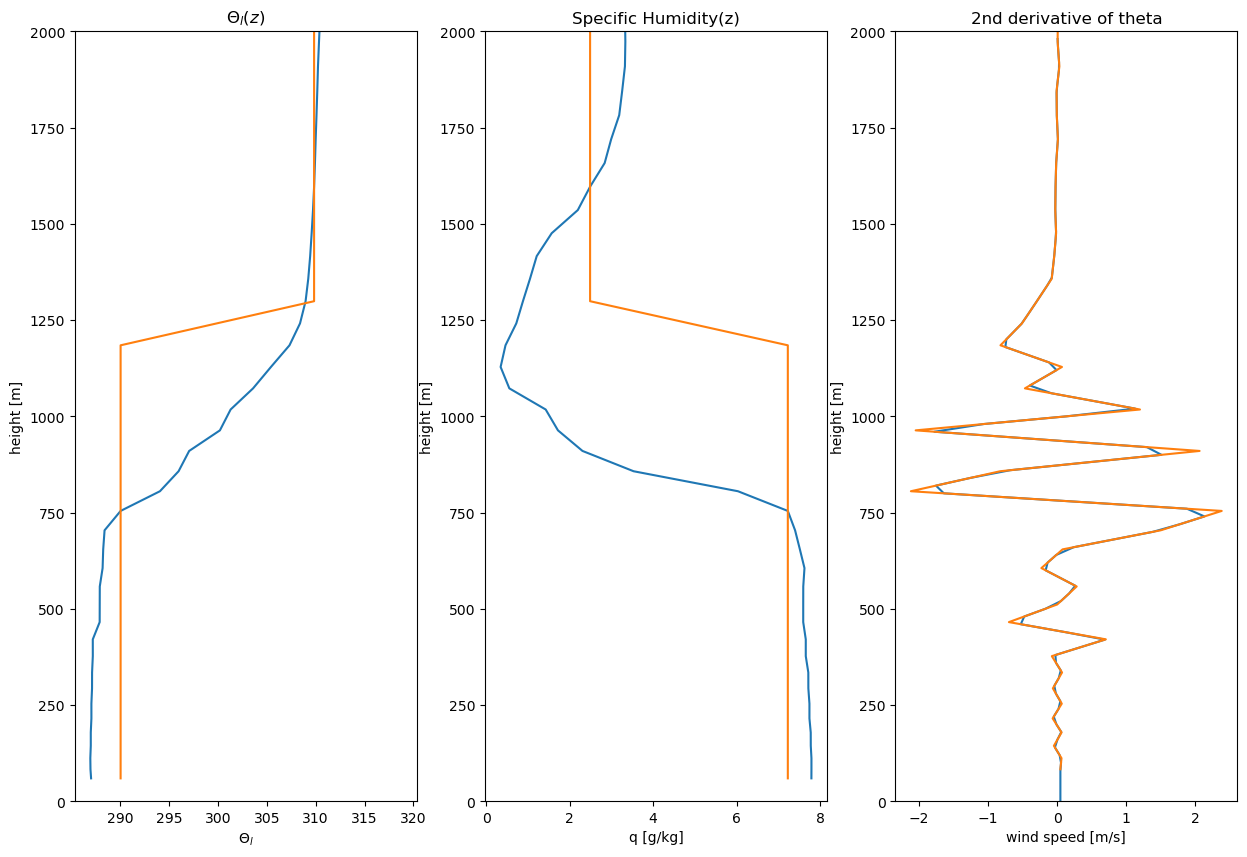

In [7]:
# IQQ profile:

# iqq22 = "/home/alexander/Documents/Soundings_IQQ/sound_in_IQQ2018-08-22T09 13 00"
# iqq23 = "/home/alexander/Documents/Soundings_IQQ/sound_in_IQQ2018-08-23T21 37 59"
# ps, zs, Thetas, qs, us, vs = read_sounding_file(iqq23)
550.0
625.0
700.0
800.0
900.0
1000.0
1150.0

new_Thetas, new_qs = new_sharpen_inversion(zs, Thetas,qs, zb=1150, dz=151, zi=zi, between=[750,1600])

fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.title("")
axs[0].set_title("$\Theta_l(z)$")
axs[0].plot(Thetas, zs)
axs[0].plot(new_Thetas, zs)
axs[0].set_xlabel("$\Theta_l$")
axs[0].set_ylabel("height [m]")
axs[0].set_ylim(0,2000)

axs[1].set_title("Specific Humidity(z)")
axs[1].plot(qs, zs)
axs[1].plot(new_qs, zs)
axs[1].set_xlabel("q [g/kg]")
axs[1].set_ylabel("height [m]")
axs[1].set_ylim(0,2000)

axs[2].set_title("2nd derivative of theta")
# numpy.interp(np.arange(0, len(a), 1.5), np.arange(0, len(a)), a)
# axs[2].plot(np.sqrt(us**2 + vs**2), zs)
interpolated_derivative = np.interp(np.arange(0,2000,20), zs[1:-1], np.diff(np.diff(Thetas)))
axs[2].plot(interpolated_derivative, np.arange(0,2000,20))
# axs[2].plot(np.diff(np.diff(Thetas)/np.diff(zs))/np.diff(zs[1:]), zs[1:-1])
axs[2].plot(np.diff(np.diff(Thetas)), zs[1:-1])
axs[2].set_xlabel("wind speed [m/s]")
axs[2].set_ylabel("height [m]")
axs[2].set_ylim(0,2000)
plt.savefig("/home/alexander/Pictures/foghat_iqq23_sharp.png", facecolor="white")


write_sounding_string(ps=ps, zs=zs, Thetas=new_Thetas,\
                          qs=new_qs, us=us, vs=vs, zmax=5000,
                         filename = "foghat_iqq23_sharp")